In [26]:
#@markdown *Last running requirement version*

# !python -V

# uncomment line below if you are using Linux or Google Colab
# !pip freeze | grep -w 'requests'
# !pip freeze | grep -w 'pandas'
# !pip freeze | grep -w 'mercury'
# !pip freeze | grep -w 'ptitprince'
# !pip freeze | grep -w 'scipy'
# !pip freeze | grep -w 'matplotlib'
# !pip freeze | grep -w 'category-encoders'
# !pip freeze | grep -w 'scikit-learn'

# uncomment line below if you are using Windows
# !pip freeze | findstr /C:"requests"
# !pip freeze | findstr /C:"pandas"
# !pip freeze | findstr /C:"mercury"
# !pip freeze | findstr /C:"ptitprince"
# !pip freeze | findstr /C:"scipy"
# !pip freeze | findstr /C:"matplotlib"
# !pip freeze | findstr /C:"category-encoders"
# !pip freeze | findstr /C:"scikit-learn"

## Data Preprocessing

In [27]:
import os

import requests
import pandas as pd
import mercury as mr
import ptitprince as pt
from scipy.io import arff
import matplotlib.pyplot as plt
from category_encoders import LeaveOneOutEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# xkcd-styled & humor sans font installed to give semi-sarcasm graph
plt.xkcd()
%matplotlib inline

### Constants and Helper Functions

In [28]:
# consts
TUNGUZ_DATASET_REPO_URL = 'https://raw.githubusercontent.com/tunguz/TabularBenchmarks/main/datasets/credit-g/input/'
ARFF_DATASET = 'dataset_31_credit-g.arff'
RANDOM_SEED = 42
TEST_SIZE = .3
ISSKEWED = 'isSkewed'

In [29]:
def categorize_skewness(skew: float) -> str:
    magnitude = ''
    direction = ''
    if abs(skew) <= .5:
        magnitude = 'Normal'
    elif abs(skew) <= 1:
        magnitude = 'Moderate'
    elif abs(skew) <= 2:
        magnitude = 'High'
    elif abs(skew) > 2:
        magnitude = 'Extreme'
    else:
        return 'Undefined'
    
    if skew == 0:
        direction = 'Gaussian'
    elif skew > 0:
        direction = 'Positive'
    else:
        direction = 'Negative'
    
    return f'{magnitude} {direction}'
    
def categorize_excess_kurtosis(kurt: float) -> str:
    if -.5 <= kurt <= .5:
        return 'Normal / Mesokurtic'
    elif kurt > .5:
        return 'Positive / Leptokurtic'
    elif kurt < -.5:
        return 'Negative / Platykurtic'
    else:
        return 'Undefined'

def is_skewed(skew: float) -> bool:
    return abs(skew) > .5

def plot_bar(s: pd.Series, figsize: tuple = (9, 7)):
    '''Plot nominal label/feature bar purpose only'''
    label_counts = s.value_counts()
    total = sum(label_counts.values)
    desc_series = s.describe()
    count, top = int(desc_series[0]), desc_series[2]

    plt.figure(figsize=figsize)
    bars = plt.bar(label_counts.index, label_counts.values)
    plt.xticks(rotation=45)
    plt.xlabel(f'{s.name} Label')
    plt.ylabel('Count')
    plt.title(f'Bar Plot of {s.name}')
    get_x_right = lambda x, y: ((y - x) * .75) + x
    x_right = get_x_right(*plt.gca().get_xlim())
    y_min, y_max = plt.gca().get_ylim()
    y_range = y_max - y_min

    # Adding the counts above the bars
    for idx, bar in enumerate(bars):
        yval = bar.get_height()
        label = label_counts.index[idx]
        is_top = label == top
        label_text = f"Top\n{yval}\n({yval/total:.2%})" if is_top else f"{yval}\n({yval/total:.2%})"
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval + .1,
            label_text,
            ha='center',
            va='bottom')

    # Adding the total count
    bbox = dict(boxstyle='round', facecolor='yellow', alpha=.5)
    plt.text(
        x_right,
        .95 * y_range + y_min,
        f"Total: {count}",
        verticalalignment='top',
        bbox=bbox
    )
    plt.tight_layout()
    plt.show()

def plot_histogram(s: pd.Series):
    '''Plot numerical features histogram purpose only'''
    plt.figure(figsize=(9, 7))
    plt.hist(s, bins='auto', edgecolor='black')

    desc_series = s.describe()
    count = int(desc_series[0])
    std = desc_series[2]
    min = desc_series[3]
    q1 = desc_series[4]
    q3 = desc_series[6]
    max = desc_series[-1]
    mean = s.mean()
    median = s.median()
    mode = s.mode().values[0]
    y_min, y_max = plt.gca().get_ylim()
    get_x_center = lambda x, y: ((y - x) * .3) + x
    x_center =  get_x_center(*plt.gca().get_xlim())

    plt.axvline(min, color='orange', linestyle='solid', linewidth=2)
    plt.axvline(max, color='purple', linestyle='solid', linewidth=2)
    plt.axvline(q1, color='magenta', linestyle='dashed', linewidth=2)
    plt.axvline(median, color='blue', linestyle='dashed', linewidth=2)
    plt.axvline(q3, color='cyan', linestyle='dashed', linewidth=2)
    plt.axvline(mean, color='red', linestyle='dotted', linewidth=2)
    plt.axvline(mode, color='green', linestyle='dashdot', linewidth=2)

    y_range = y_max - y_min
    y_text = [ i / 10 * y_range + y_min for i in range(1, 8) ]

    plt.text(min, y_text[0], f'Min: {min:.2f}', color='orange')
    plt.text(max, y_text[1], f'Max: {max:.2f}', color='purple')
    plt.text(q1, y_text[2], f'Q1: {q1:.2f}', color='magenta')
    plt.text(median, y_text[3], f'Median: {median:.2f}', color='blue')
    plt.text(q3, y_text[4], f'Q3: {q3:.2f}', color='cyan')
    plt.text(mean, y_text[5], f'Mean: {mean:.2f}', color='red')
    plt.text(mode, y_text[6], f'Mode: {mode:.2f}', color='green')

    bbox = dict(boxstyle='round', facecolor='yellow', alpha=.5)
    plt.text(
        x_center,
        .95 * y_range + y_min,
        f"Total: {count}\nStandar deviation: {std:.2f}",
        verticalalignment='top',
        bbox=bbox
    )

    plt.title(f'Histogram of {s.name}')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.legend({
        'Min':min,
        'Max':max,
        'Q1':q1,
        'Median':median,
        'Q3':q3,
        'Mean':mean,
        'Mode':mode
        },
        loc='upper center',
        bbox_to_anchor=(.5,-0.15),
        ncol=7
    )
    plt.tight_layout()
    plt.show()

def plot_bar_histogram(s_bar: pd.Series, s_hist: pd.Series):
    '''Plot bar and histogram for side-by-side comparison'''
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

    # ===== Bar Plot =====
    label_counts = s_bar.value_counts()
    total = sum(label_counts.values)
    desc_series = s_bar.describe()
    count, top = int(desc_series[0]), desc_series[2]
    
    bars = axs[0].bar(label_counts.index, label_counts.values)
    axs[0].set_xticks(range(len(label_counts.index)))
    axs[0].set_xticklabels(label_counts.index, rotation=45)
    axs[0].set_xlabel(f'{s_bar.name} Label')
    axs[0].set_ylabel('Count')
    axs[0].set_title(f'Bar Plot of {s_bar.name}')
    get_x_right = lambda x, y: ((y - x) * .75) + x
    x_right = get_x_right(*axs[0].get_xlim())
    y_min, y_max = axs[0].get_ylim()
    y_range = y_max - y_min

    for idx, bar in enumerate(bars):
        yval = bar.get_height()
        label = label_counts.index[idx]
        is_top = label == top
        label_text = f"Top\n{yval}\n({yval/total:.2%})" if is_top else f"{yval}\n({yval/total:.2%})"
        axs[0].text(
            bar.get_x() + bar.get_width() / 2,
            yval + .1,
            label_text,
            ha='center',
            va='bottom')

    # Adding the total count
    bbox = dict(boxstyle='round', facecolor='yellow', alpha=.5)
    axs[0].text(
        x_right,
        .95 * y_range + y_min,
        f"Total: {count}",
        verticalalignment='top',
        bbox=bbox
    )
    
    # ===== Histogram Plot =====
    axs[1].hist(s_hist, bins='auto', edgecolor='black')
    desc_series = s_hist.describe()
    count = int(desc_series[0])
    std = desc_series[2]
    min = desc_series[3]
    q1 = desc_series[4]
    q3 = desc_series[6]
    max = desc_series[-1]
    mean = s_hist.mean()
    median = s_hist.median()
    mode = s_hist.mode().values[0]

    y_min, y_max = axs[1].get_ylim()
    get_x_center = lambda x, y: ((y - x) * .3) + x
    x_center = get_x_center(*axs[1].get_xlim())

    axs[1].axvline(min, color='orange', linestyle='solid', linewidth=2)
    axs[1].axvline(max, color='purple', linestyle='solid', linewidth=2)
    axs[1].axvline(q1, color='magenta', linestyle='dashed', linewidth=2)
    axs[1].axvline(median, color='blue', linestyle='dashed', linewidth=2)
    axs[1].axvline(q3, color='cyan', linestyle='dashed', linewidth=2)
    axs[1].axvline(mean, color='red', linestyle='dotted', linewidth=2)
    axs[1].axvline(mode, color='green', linestyle='dashdot', linewidth=2)

    y_range = y_max - y_min
    y_text = [ i / 10 * y_range + y_min for i in range(1,8) ]
    
    axs[1].text(min, y_text[0], f'Min: {min:.2f}', color='orange')
    axs[1].text(max, y_text[1], f'Max: {max:.2f}', color='purple')
    axs[1].text(q1, y_text[2], f'Q1: {q1:.2f}', color='magenta')
    axs[1].text(median, y_text[3], f'Median: {median:.2f}', color='blue')
    axs[1].text(q3, y_text[4], f'Q3: {q3:.2f}', color='cyan')
    axs[1].text(mean, y_text[5], f'Mean: {mean:.2f}', color='red')
    axs[1].text(mode, y_text[6], f'Mode: {mode:.2f}', color='green')

    bbox = dict(boxstyle='round', facecolor='yellow', alpha=.5)
    axs[1].text(
        x_center,
        .95 * y_range + y_min,
        f"Total: {count}\nStandard deviation: {std:.2f}",
        verticalalignment='top',
        bbox=bbox
    )

    axs[1].set_title(f'Histogram of {s_hist.name}')
    axs[1].set_xlabel('Values')
    axs[1].set_ylabel('Frequency')
    axs[1].legend({
        'Min':min,
        'Max':max,
        'Q1':q1,
        'Median':median,
        'Q3':q3,
        'Mean':mean,
        'Mode':mode
        },
        loc='upper center',
        bbox_to_anchor=(.5,-0.15),
        ncol=7
    )

    plt.tight_layout()
    plt.show()

def plot_histogram_comparison(train_series: pd.Series, test_series: pd.Series):
    '''Plot 2 features histogram side by side for comparison purpose only'''
    sequences = ('Train', 'Test')
    _, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    for s, ax, seq in zip((train_series, test_series), axes, sequences):
        ax.hist(s, bins='auto', edgecolor='black')

        desc_series = s.describe()
        count = int(desc_series[0])
        std = desc_series[2]
        min = desc_series[3]
        q1 = desc_series[4]
        q3 = desc_series[6]
        max = desc_series[-1]
        mean = s.mean()
        median = s.median()
        mode = s.mode().values[0]
        skewness = s.skew()
        kurtosis = s.kurt()
        skew_category = categorize_skewness(skewness)
        kurt_category = categorize_excess_kurtosis(kurtosis)
        
        y_min, y_max = ax.get_ylim()
        get_x_center = lambda x, y: ((y - x) * .25) + x
        x_center =  get_x_center(*ax.get_xlim())

        ax.axvline(min, color='orange', linestyle='solid', linewidth=2)
        ax.axvline(max, color='purple', linestyle='solid', linewidth=2)
        ax.axvline(q1, color='magenta', linestyle='dashed', linewidth=2)
        ax.axvline(median, color='blue', linestyle='dashed', linewidth=2)
        ax.axvline(q3, color='cyan', linestyle='dashed', linewidth=2)
        ax.axvline(mean, color='red', linestyle='dotted', linewidth=2)
        ax.axvline(mode, color='green', linestyle='dashdot', linewidth=2)

        y_range = y_max - y_min
        y_text = [ i / 12 * y_range + y_min for i in range(1, 8) ]

        ax.text(min, y_text[0], f'Min: {min:.2f}', color='orange')
        ax.text(max, y_text[1], f'Max: {max:.2f}', color='purple')
        ax.text(q1, y_text[2], f'Q1: {q1:.2f}', color='magenta')
        ax.text(median, y_text[3], f'Median: {median:.2f}', color='blue')
        ax.text(q3, y_text[4], f'Q3: {q3:.2f}', color='cyan')
        ax.text(mean, y_text[5], f'Mean: {mean:.2f}', color='red')
        ax.text(mode, y_text[6], f'Mode: {mode:.2f}', color='green')
        
        bbox = dict(boxstyle='round', facecolor='yellow', alpha=.5)
        ax.text(
            x_center,
            .95 * y_range + y_min,
            f"Total: {count}\nStandard deviation: {std:.2f}\n"
            f"Kurtosis: {kurtosis:.2f} ({kurt_category})\n"
            f"Skewness: {skewness:.2f} ({skew_category})",
            verticalalignment='top',
            bbox=bbox
        )

        ax.set_title(f'{seq}: Histogram of "{s.name}"')
        ax.set_xlabel('Values')
        ax.set_ylabel('Frequency')
        ax.legend({
            'Min':min,
            'Max':max,
            'Q1':q1,
            'Median':median,
            'Q3':q3,
            'Mean':mean,
            'Mode':mode
            },
            loc='upper center',
            bbox_to_anchor=(.5,-0.15),
            ncol=4
        )

    plt.tight_layout()
    plt.show()

def plot_histogram_sk(s: pd.Series):
    '''Plot numerical features histogram with skewness and kurtosis addition'''
    plt.figure(figsize=(9, 7))
    plt.hist(s, bins='auto', edgecolor='black')

    desc_series = s.describe()
    count = int(desc_series[0])
    std = desc_series[2]
    min = desc_series[3]
    q1 = desc_series[4]
    q3 = desc_series[6]
    max = desc_series[-1]
    mean = s.mean()
    median = s.median()
    mode = s.mode().values[0]
    skewness = s.skew()
    kurtosis = s.kurt()
    skew_category = categorize_skewness(skewness)
    kurt_category = categorize_excess_kurtosis(kurtosis)

    y_min, y_max = plt.gca().get_ylim()
    get_x_center = lambda x, y: ((y - x) * .25) + x
    x_center =  get_x_center(*plt.gca().get_xlim())

    plt.axvline(min, color='orange', linestyle='solid', linewidth=2)
    plt.axvline(max, color='purple', linestyle='solid', linewidth=2)
    plt.axvline(q1, color='magenta', linestyle='dashed', linewidth=2)
    plt.axvline(median, color='blue', linestyle='dashed', linewidth=2)
    plt.axvline(q3, color='cyan', linestyle='dashed', linewidth=2)
    plt.axvline(mean, color='red', linestyle='dotted', linewidth=2)
    plt.axvline(mode, color='green', linestyle='dashdot', linewidth=2)

    y_range = y_max - y_min
    y_text = [ i / 12 * y_range + y_min for i in range(1, 8) ]

    plt.text(min, y_text[0], f'Min: {min:.2f}', color='orange')
    plt.text(max, y_text[1], f'Max: {max:.2f}', color='purple')
    plt.text(q1, y_text[2], f'Q1: {q1:.2f}', color='magenta')
    plt.text(median, y_text[3], f'Median: {median:.2f}', color='blue')
    plt.text(q3, y_text[4], f'Q3: {q3:.2f}', color='cyan')
    plt.text(mean, y_text[5], f'Mean: {mean:.2f}', color='red')
    plt.text(mode, y_text[6], f'Mode: {mode:.2f}', color='green')

    bbox = dict(boxstyle='round', facecolor='yellow', alpha=.5)
    plt.text(
        x_center,
        .95 * y_range + y_min,
        f"Total: {count}\nStandard deviation: {std:.2f}\n"
        f"Kurtosis: {kurtosis:.2f} ({kurt_category})\n"
        f"Skewness: {skewness:.2f} ({skew_category})",
        verticalalignment='top',
        bbox=bbox
    )

    plt.title(f'Histogram of {s.name}')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.legend({
        'Min':min,
        'Max':max,
        'Q1':q1,
        'Median':median,
        'Q3':q3,
        'Mean':mean,
        'Mode':mode
        },
        loc='upper center',
        bbox_to_anchor=(.5,-0.15),
        ncol=7
    )
    plt.tight_layout()
    plt.show()

def plot_raincloud_comparison(train_series: pd.Series, test_series: pd.Series):
    '''Plot 2 features raincloud side by side for comparison purpose only'''
    df1 = pd.DataFrame({train_series.name: train_series, 'Group': 'Train'})
    df2 = pd.DataFrame({test_series.name: test_series, 'Group': 'Test'})
    df = pd.concat([df1, df2], ignore_index=True)

    plt.figure(figsize=(18, 7))
    _ = pt.RainCloud(
        x='Group',
        y=train_series.name,
        data=df,
        width_viol=.6,
        width_box=.2,
        orient='h',
        ax=None,
        move=0
    )

    plt.title(f'Raincloud Plot Comparison of {train_series.name}')
    plt.xlabel('Values')
    plt.ylabel('Density')
    plt.show()

def check_missing_df(df: pd.DataFrame):
    '''Check missing data on features only'''
    total_values = df.size
    if df.isnull().any().any():
        print("There are missing values in the dataframe.")
        if df.isnull().any().sum() > 0:
            print("\nColumns with missing values:")
            print(df.isnull().sum()[df.isnull().sum() > 0])
        total_missing = df.isnull().sum().sum()
        print("\nTotal number of missing values: ", total_missing)
        print(f"Ratio of missing values: {total_missing}/{total_values} = {total_missing / total_values:.2}")
        print(f"Percentage of missing values = {total_missing / total_values:.2%}")
    else:
        print("There are no missing values in the dataframe.")

def check_missing_s(s: pd.Series):
    '''Check missing data on labels only'''
    total_values = s.size
    if s.isnull().any():
        print("There are missing values in the series.")
        total_missing = s.isnull().sum()
        print("Total number of missing values: ", total_missing)
        print(f"Ratio of missing values: {total_missing}/{total_values} = {total_missing / total_values:.2}")
        print(f"Percentage of missing values = {total_missing / total_values:.2%}")
    else:
        print("There are no missing values in the series.")

def check_duplicates_df(df: pd.DataFrame):
    '''Check duplicate data on DataFrame'''
    total_rows = df.shape[0]
    if df.duplicated().any():
        print("There are duplicated rows in the dataframe.")
        total_duplicates = df.duplicated().sum()
        print(f"\nTotal number of duplicated rows: {total_duplicates}")
        print(f"Ratio of duplicated rows: {total_duplicates}/{total_rows} = {total_duplicates / total_rows:.2}")
        print(f"Percentage of duplicated rows = {total_duplicates / total_rows:.2%}")

        # Print duplicated rows (showing first few rows)
        duplicated_rows = df[df.duplicated()]
        print("\nPreview of duplicated rows:")
        print(duplicated_rows)
    else:
        print("There are no duplicated rows in the dataframe.")

def desc_stats(df: pd.DataFrame) -> pd.DataFrame:
    '''Return descriptive statistics of the given dataframe'''
    desc_stats_df = df.describe()
    skewness = df.apply(lambda x: round(x.skew(), 6)).to_frame().T
    kurtosis = df.apply(lambda x: round(x.kurt(), 6)).to_frame().T
    is_skewed_df = skewness.applymap(is_skewed)
    skewness.index = ['skew']
    kurtosis.index = ['kurt']
    is_skewed_df.index = [ISSKEWED]
    desc_stats_df = pd.concat([desc_stats_df, skewness, kurtosis, is_skewed_df])
    return desc_stats_df

def get_skewed_features(desc_stats_df = pd.DataFrame) -> set:
    '''Return set of skewed features given the dataframe'''
    skewed_features = desc_stats_df.loc[ISSKEWED] == True
    skewed_features = {*skewed_features[skewed_features == True].index.tolist()}
    return skewed_features

def get_difference_set(left_set: set, right_set: set) -> dict:
    '''Return the difference between two sets'''
    return {
        'left_set': left_set - right_set,
        'right_set': right_set - left_set
        }

def get_union_set(set1: set, set2: set) -> list:
    '''Return the union of the given sets'''
    return list(set1 | set2)



In [30]:
app = mr.App(
    title="German Credit EDA 📊",
    description="Interactive Presentation of German Credit Explanatory Data Analysis",
    stop_on_error=True
)

mercury.App

In [31]:
mr.Markdown("# German Credit EDA - Interactive Presentation 📝")

# German Credit EDA - Interactive Presentation 📝

In [32]:
mr.Markdown("""## Recompute Slides Hints 💻

- This is powered by <a href='https://github.com/mljar/mercury' target='_blank'>Mercury</a>
- You can interact with all available widgets
- Enter full screen by pressing **F** and exit with **Esc**
- Use ◀ ▶ for slide navigation
- Use 🔼 🔽 for subslide / fragment navigation
""")

## Recompute Slides Hints 💻

- This is powered by <a href='https://github.com/mljar/mercury' target='_blank'>Mercury</a>
- You can interact with all available widgets
- Enter full screen by pressing **F** and exit with **Esc**
- Use ◀ ▶ for slide navigation
- Use 🔼 🔽 for subslide / fragment navigation


### Preprocessing

In [33]:
# loading the arrf dataset
url = f'{TUNGUZ_DATASET_REPO_URL}{ARFF_DATASET}'

if os.path.exists(ARFF_DATASET):
    with open(ARFF_DATASET, 'rt') as f:
        data, meta = arff.loadarff(f)
else:
    response = requests.get(url)
    if response.status_code == 200:
        with open(ARFF_DATASET, 'wb') as f:
            f.write(response.content)
        # Reopen the file in text mode for reading with arff.loadarff
        with open(ARFF_DATASET, 'rt') as f:
            data, meta = arff.loadarff(f)
    else:
        print(f"Couldn't download the file: {url}")

df = pd.DataFrame(data)

## Attribute Description ⚒

Features:

| no | attribute | unique_values | description | nominal | ordinal | ratio |
| --- | --- | --- | --- | --- | --- | --- |
| 1 | `checking_status` | ['<0', '0<=X<200', 'no checking', '>=200'] |  Status of existing checking account. **People with lower balances might be seen as higher risk.** | ✔ | there are order | - |
| 2 | `duration` | [4, 72] **inclusive range not unique values** | Duration in month. **Longer loan durations might be riskier as they offer more opportunities for the borrower's circumstances to change.** | - | long or short | ✔ |

| no | attribute | unique_values | description | nominal | ordinal | ratio |
| --- | --- | --- | --- | --- | --- | --- |
| 3 | `credit_history` | ['critical/other existing credit', 'existing paid', 'delayed previously', 'no credits/all paid', 'all paid'] | The applicant’s track record in terms of past loans. **A history of delinquency could point to higher risk.** | ✔ | - | - |
| 4 | `purpose` | ['radio/tv', 'education', 'furniture/equipment', 'new car', 'used car', 'business', 'domestic appliance', 'repairs', 'other', 'retraining'] | Purpose for the loan. **Certain loan purposes might be associated with higher risk than others (e.g., starting a new business might be riskier than buying a car).** | ✔ | - | - |

| no | attribute | unique_values | description | nominal | ordinal | ratio |
| --- | --- | --- | --- | --- | --- | --- |
| 5 | `credit_amount` | [250, 18424] **inclusive range not unique values** | The amount of loan in question. **Larger loans might be considered higher risk.** | - | small or big | ✔ |
| 6 | `savings_status` | ['no known savings', '<100', '500<=X<1000', '>=1000', '100<=X<500'] | Savings account/bonds. **Those with more savings might be considered lower risk.** | ✔ | there are order | - |

| no | attribute | unique_values | description | nominal | ordinal | ratio |
| --- | --- | --- | --- | --- | --- | --- |
| 7 | `employment` | ['>=7', '1<=X<4', '4<=X<7', 'unemployed', '<1'] | Present employment since. **Longer employment might be seen as indicating more stable income.** | ✔ | there are order | - |
| 8 | `installment_commitment` | [1, 2, 3, 4] | Installment rate in percentage of disposable income. **Higher percentages could indicate financial strain and higher risk.** | - | low or high | ✔ |

| no | attribute | unique_values | description | nominal | ordinal | ratio |
| --- | --- | --- | --- | --- | --- | --- |
| 9 | `personal_status` | ['male single', 'female div/dep/mar', 'male div/sep', 'male mar/wid'] | Personal status and sex includes marital status and gender. **These factors could have complex interactions with risk.** | ✔ | - | - |
| 10 | `other_parties` | ['none', 'guarantor', 'co applicant'] | Other debtors / guarantors that indicates if there are other people who share the responsibility of the loan. **Guarantors can decrease the risk.** | ✔ | - | - |

| no | attribute | unique_values | description | nominal | ordinal | ratio |
| --- | --- | --- | --- | --- | --- | --- |
| 11 | `residence_since` | [1, 2, 3, 4] | How long the applicant has lived at their current address. **Longer times could indicate more stability.** | - | long or short | ✔ |
| 12 | `property_magnitude` | ['real estate', 'life insurance', 'no known property', 'car'] | Describes the types of property the person owns. **Describes the types of property the person owns.** | ✔ | - | - |

| no | attribute | unique_values | description | nominal | ordinal | ratio |
| --- | --- | --- | --- | --- | --- | --- |
| 13 | `age` | [19, 75] **inclusive range not unique values** | The applicant’s age. **Risk can vary with age due to factors like income stability, health status, etc.** | - | older or younger | ✔ |
| 14 | `other_payment_plans` | ['none', 'bank', 'stores'] | Other installment plans that indicates if the borrower has other ongoing loans. **Additional financial obligations can increase risk.** | ✔ | - | - |

| no | attribute | unique_values | description | nominal | ordinal | ratio |
| --- | --- | --- | --- | --- | --- | --- |
| 15 | `housing` | ['own', 'for free', 'rent'] | The type of housing the applicant lives in. **Those who own their homes might be seen as more stable/less risky.** | ✔ | - | - |
| 16 | `existing_credits` | [1, 2, 3, 4] | Number of existing credits at this bank. **Multiple loans could indicate higher risk.** | - | few or many | ✔ |

| no | attribute | unique_values | description | nominal | ordinal | ratio |
| --- | --- | --- | --- | --- | --- | --- |
| 17 | `job` | ['skilled', 'unskilled resident', 'high qualif/self emp/mgmt', 'unemp/unskilled non res'] | The applicant's job status and type. **Certain jobs might be seen as more stable/less risky.** | ✔ | - | - |
| 18 | `num_dependents` | [1, 2] | Number of people being liable to provide maintenance for. **The more dependents person has, the more of their income is likely already spoken for, which can make it riskier for the bank to lend them money.** | - | - | ✔ |

| no | attribute | unique_values | description | nominal | ordinal | ratio |
| --- | --- | --- | --- | --- | --- | --- |
| 19 | `own_telephone` | ['yes', 'none'] | Indicates if the applicant has a telephone registered under their name. **This could be seen as a sign of stability.** | ✔ | - | - |
| 20 | `foreign_worker` | ['yes', 'no'] | Indicates if the applicant is a foreign worker. **Foreign workers might be seen as higher risk due to potential job and legal uncertainties.** | ✔ | - | - |

And the label:

| no | label | unique_values | description | nominal | ordinal | ratio |
| --- | --- | --- | --- | --- | --- | --- |
| 1 | `class` | ['good', 'bad'] | Label that indicates whether the applicant is good or bad for the credit. | ✔ | - | - |

**NB:**

- There is no any nominal column that comes in a **pure numeric** form, so it is **safe for encoding** later
- **Ordinal attributes** could be made out from **either nominal or ratio attributes**, but for now we just stick with the original nominal and ratio attributes
- Because of the previous statement, there are a lot combination set of features to try on to get the optimal features for predictive model to train to
- Notice `personal_status`, which is a composite feature that includes both `gender` and `marital status`. In our current approach, these features are combined into a single attribute. However, it is possible that separating these features might provide different insights and potentially improve model performance.

### Splitting the Dataset

In [34]:
# convert the byte string into regular string and numeric into their best data type
df = df.convert_dtypes()
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.decode('utf-8')

# separating the features from the labels
features = df.drop('class', axis=1)
labels = df['class']
nominal_columns = features.select_dtypes(include='object').columns.to_list()
feature_columns = features.columns.to_list()

# split into train and test split to prevent data leakage
# stratify since we have the imbalanced classes and minority class
# and ensure consistent representation for training dataset
x_train, x_test, y_train, y_test = train_test_split(
    features,
    labels,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    shuffle=True,
    stratify=labels
    )

## Exploratory Data Analysis (EDA) 📊

### LeaveOneOut Encoding

In [35]:
# represent nominal columns in numerical way with Leave-One-Out Encoding
loo_encoder = LeaveOneOutEncoder(drop_invariant=True, return_df=True)
label_encoder = LabelEncoder()
numeric_x_train = loo_encoder.fit_transform(x_train, label_encoder.fit_transform(y_train))
numeric_x_test = loo_encoder.transform(x_test)
numeric_x_train = numeric_x_train.astype(float)
numeric_x_test = numeric_x_test.astype(float)

In [36]:
_ = mr.Note(text='---')
is_train_dataset = mr.Checkbox(
    label='Train dataset',
    value=True
)

---

mercury.Checkbox

---

**Leave One Out Encoding Transformation**

mercury.Select

In [ ]:
_ = mr.Note(text='---')
_ = mr.Note(text='**Leave One Out Encoding Transformation**')
nominal_selection = mr.Select(
    label='Nominal column',
    value=nominal_columns[0],
    choices=nominal_columns
    )

### Leave One Out Encoding 📊
Please change `Train dataset` and `Nominal column` to see the changes before and after the encoding in particular dataset.
The plot will automatically updated. See the individual plot on the below subslides.


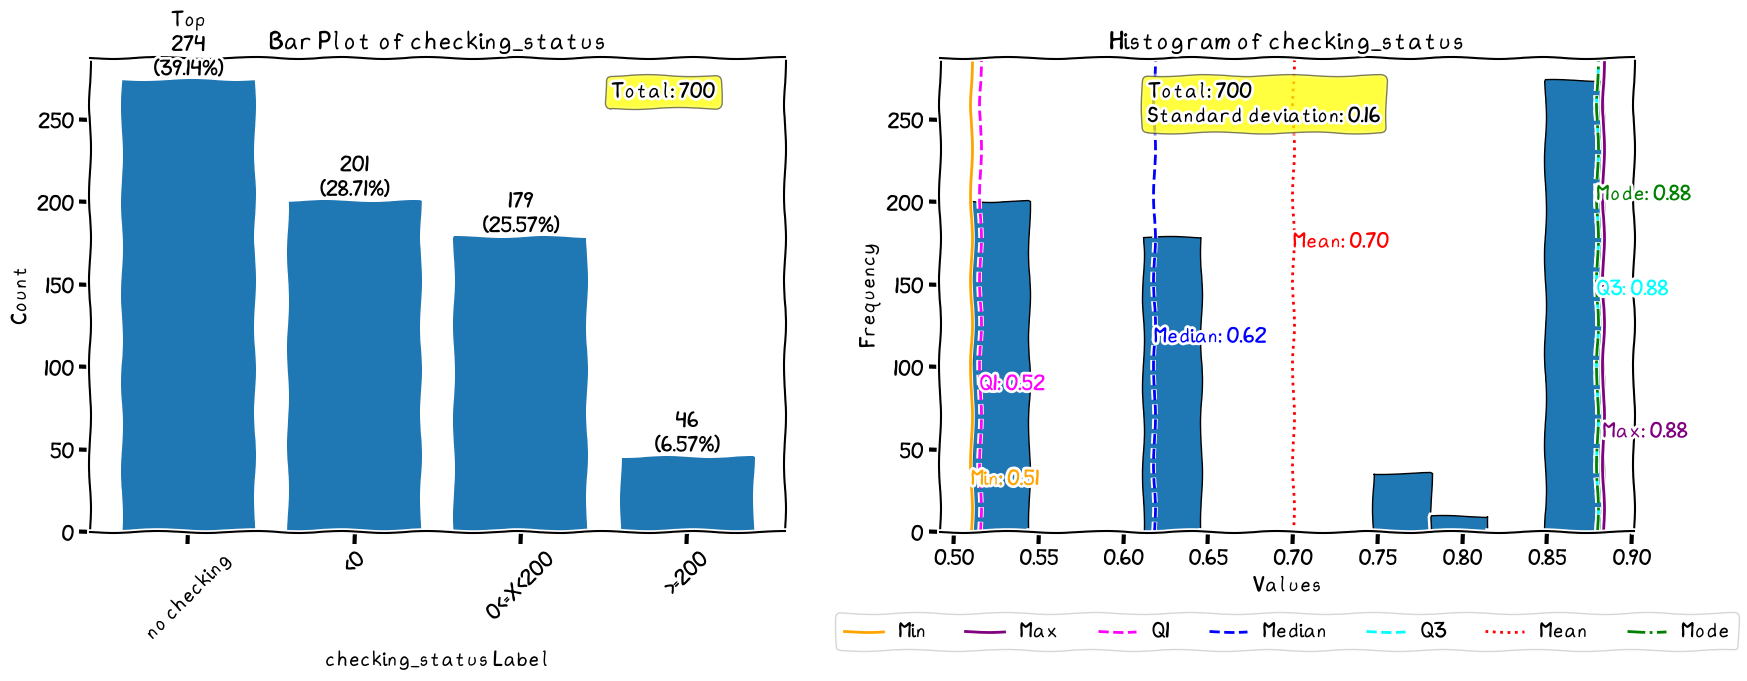

In [37]:
mr.Markdown("""### Leave One Out Encoding 📊
Please change `Train dataset` and `Nominal column` to see the changes before and after the encoding in particular dataset.
The plot will automatically updated. See the individual plot on the below subslides.
""")
if is_train_dataset.value:
    plot_bar_histogram(x_train[nominal_selection.value], numeric_x_train[nominal_selection.value])
else:
    plot_bar_histogram(x_test[nominal_selection.value], numeric_x_test[nominal_selection.value])

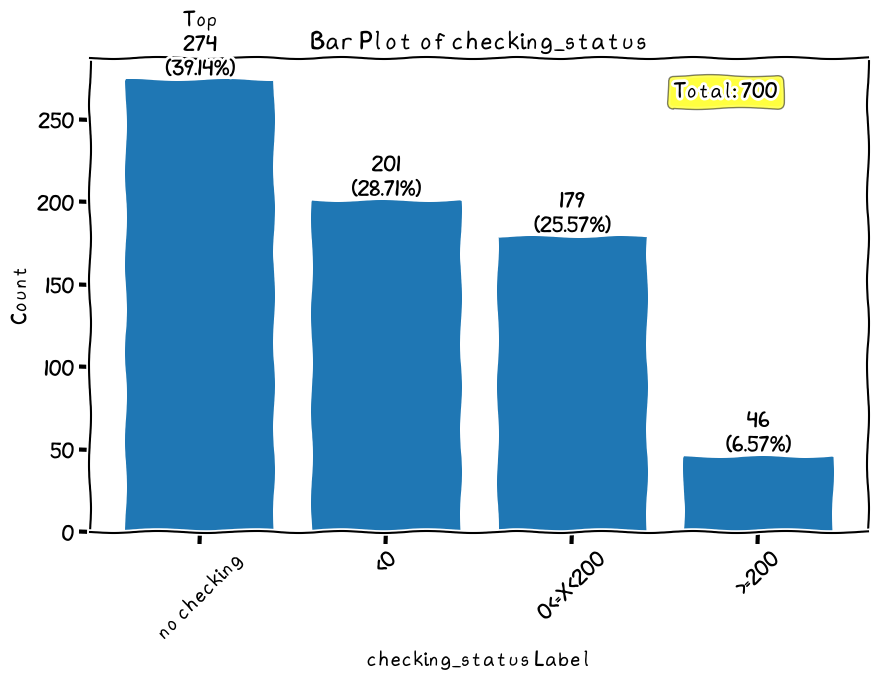

In [38]:
if is_train_dataset.value:
    plot_bar(x_train[nominal_selection.value])
else:
    plot_bar(x_test[nominal_selection.value])

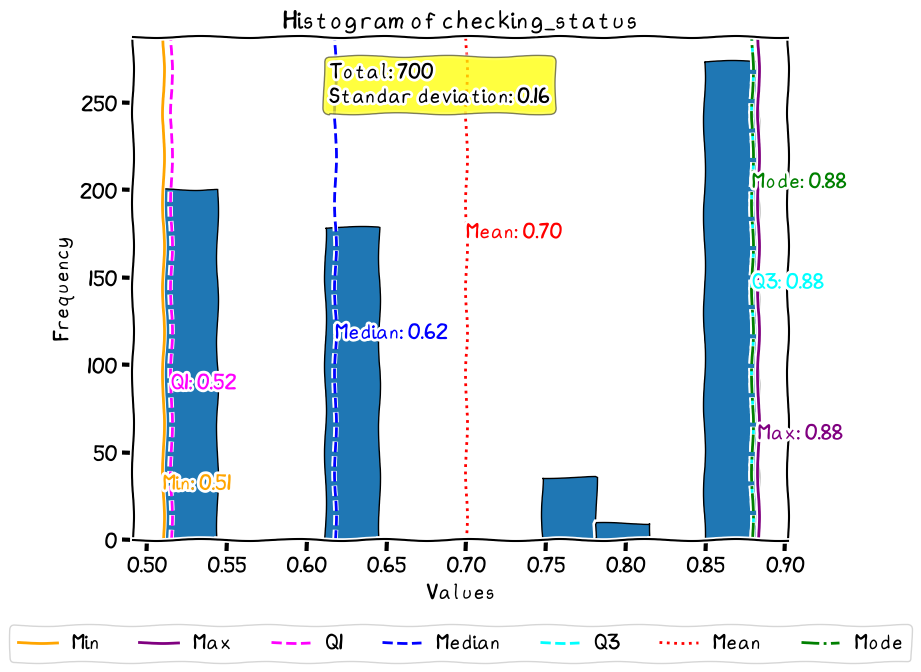

In [39]:
if is_train_dataset.value:
    plot_histogram(numeric_x_train[nominal_selection.value])
else:
    plot_histogram(numeric_x_test[nominal_selection.value])

In [40]:
mr.Markdown(f""" ### Check Missing Data ✅
Train Dataset:""")
check_missing_df(numeric_x_train)
check_missing_s(y_train)

 ### Check Missing Data ✅
Train Dataset:

There are no missing values in the dataframe.
There are no missing values in the series.


In [41]:
mr.Markdown("Test Dataset:")
check_missing_df(numeric_x_test)
check_missing_s(y_test)

Test Dataset:

There are no missing values in the dataframe.
There are no missing values in the series.


In [42]:
mr.Markdown(f""" ### Check Duplicated Data ☑
Train Dataset:""")
check_duplicates_df(numeric_x_train)

 ### Check Duplicated Data ☑
Train Dataset:

There are no duplicated rows in the dataframe.


In [43]:
mr.Markdown("Test Dataset:")
check_duplicates_df(numeric_x_test)

Test Dataset:

There are no duplicated rows in the dataframe.


### Descriptive Statistics

In [44]:
_ = mr.Note(text='---')
_ = mr.Note(text='**Descriptive Statistics & Histogram** (after Leave One Out Encoding)')
_ = mr.Note(text='**Raincloud Plot**')
feature_selection = mr.Select(
    label='Feature column',
    value=feature_columns[0],
    choices=feature_columns
    )

---

**Descriptive Statistics & Histogram** (after Leave One Out Encoding)

**Raincloud Plot**

mercury.Select

### Descriptive Statistics & Histogram 📈
Please change `Feature column` to see particular feature from both datasets.
The plot will automatically updated. See the individual plot on the below subslides.
For now we just focus on skewness of the feature and let information of the kurtosis be the complement.
If the skewness category is not normal, we transform it later.


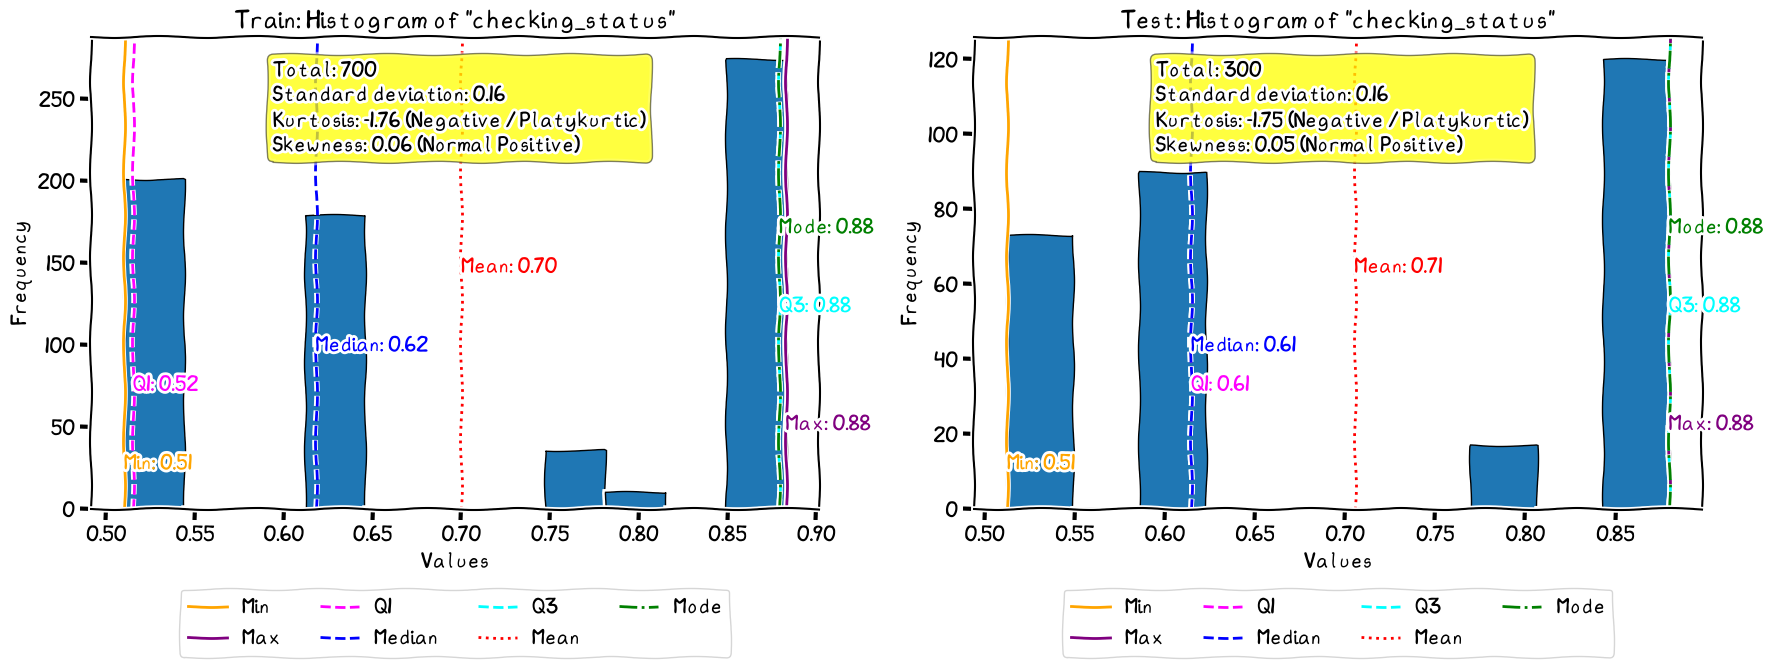

In [45]:
mr.Markdown("""### Descriptive Statistics & Histogram 📈
Please change `Feature column` to see particular feature from both datasets.
The plot will automatically updated. See the individual plot on the below subslides.
For now we just focus on skewness of the feature and let information of the kurtosis be the complement.
If the skewness category is not normal, we transform it later.
""")

plot_histogram_comparison(
    numeric_x_train[feature_selection.value],
    numeric_x_test[feature_selection.value]
    )

Train Dataset:

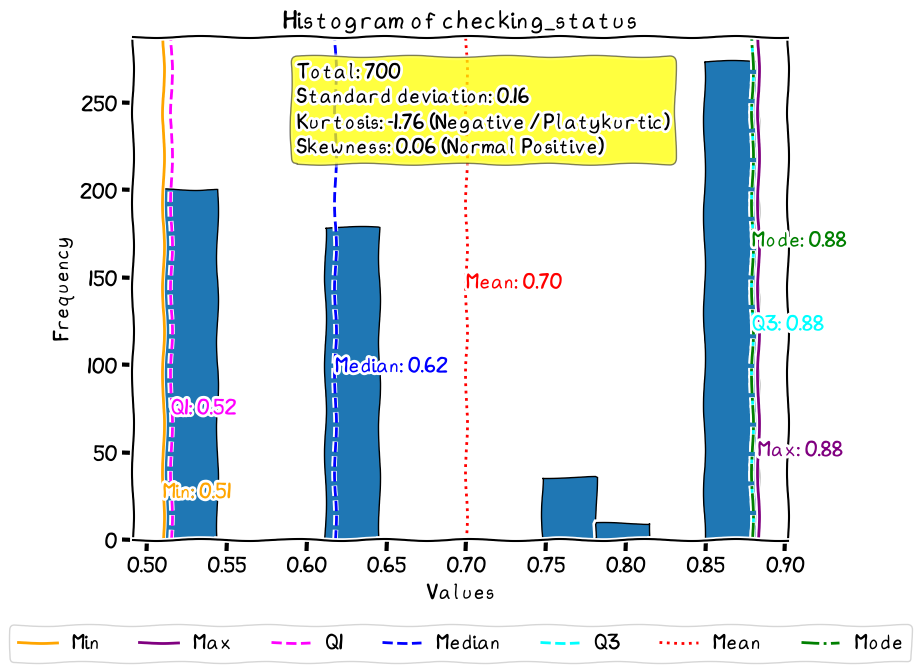

In [46]:
mr.Markdown('Train Dataset:')
plot_histogram_sk(numeric_x_train[feature_selection.value])

Test Dataset:

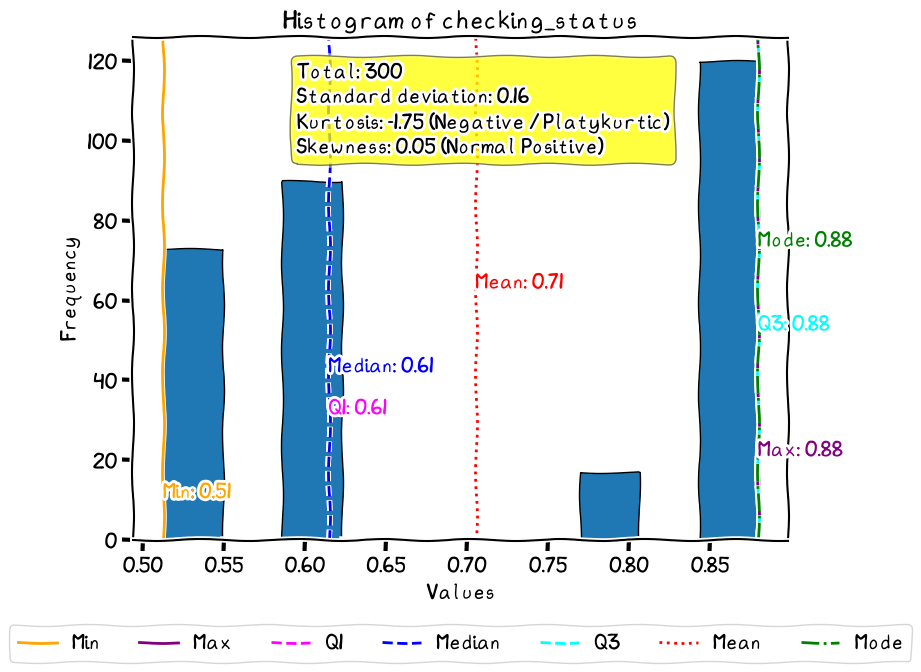

In [47]:
mr.Markdown('Test Dataset:')
plot_histogram_sk(numeric_x_test[feature_selection.value])

### Raincloud Plot 🌧
Please change `Feature column` to see particular feature from both datasets.
The plot will automatically updated.


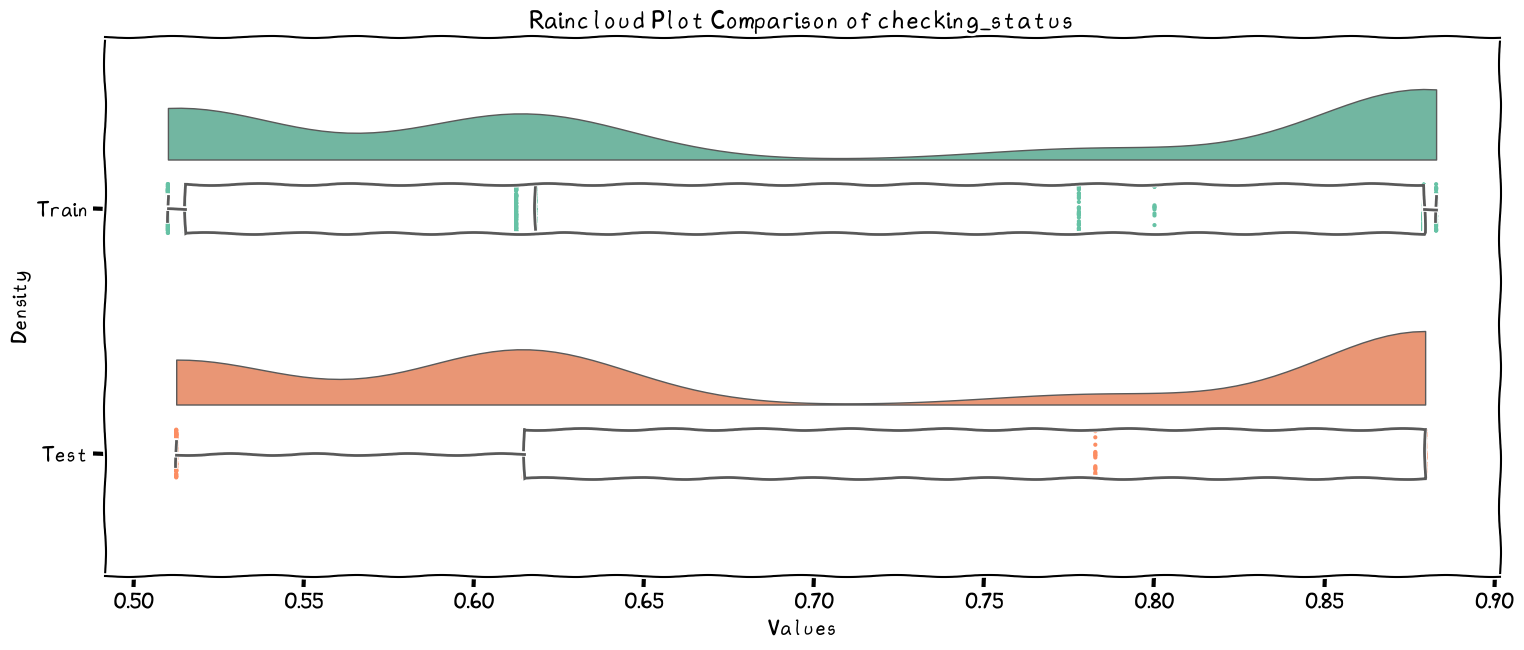

In [48]:
mr.Markdown("""### Raincloud Plot 🌧
Please change `Feature column` to see particular feature from both datasets.
The plot will automatically updated.
""")

plot_raincloud_comparison(
    numeric_x_train[feature_selection.value],
    numeric_x_test[feature_selection.value]
    )

In [49]:
x_train_desc_stats_df = desc_stats(numeric_x_train)
x_test_desc_stats_df = desc_stats(numeric_x_test)
x_train_skewed_features = get_skewed_features(x_train_desc_stats_df)
x_test_skewed_features = get_skewed_features(x_test_desc_stats_df)
diff_features = get_difference_set(x_train_skewed_features, x_test_skewed_features)

skewed_feature_df = pd.DataFrame.from_dict(
    {
    'Train': list(x_train_skewed_features),
    'Test': list(x_test_skewed_features),
    'Train-Test': list(diff_features['left_set']),
    'Test-Train': list(diff_features['right_set']),
    'Train|Test': get_union_set(x_train_skewed_features, x_test_skewed_features)
    },
    orient='index')
skewed_feature_df = skewed_feature_df.transpose()

mr.Markdown('### Skewed Features across Dataset 📉')
display(skewed_feature_df)

### Skewed Features across Dataset 📉

,Train,Test,Train-Test,Test-Train,Train|Test
0,duration,duration,None,other_parties,age
1,age,other_parties,None,None,foreign_worker
2,property_magnitude,age,None,None,employment
3,foreign_worker,property_magnitude,None,None,credit_history
4,employment,foreign_worker,None,None,existing_credits
5,other_payment_plans,employment,None,None,credit_amount
6,num_dependents,other_payment_plans,None,None,job
7,housing,num_dependents,None,None,savings_status
8,job,housing,None,None,duration
9,credit_history,job,None,None,other_parties


**NB:**

We can see there is a different of skewed data between train and test dataset in `other_parties` feature. For now, we will transform both of `other_parties` since the visual support this transformation.

### Imbalanced Dataset ⚖
Please change `Train dataset` to see label distribution from given dataset.
The plot will automatically updated.

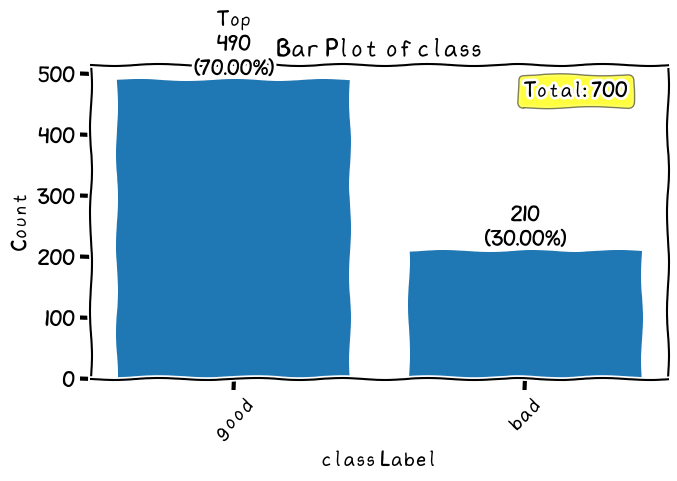

In [50]:
mr.Markdown("""### Imbalanced Dataset ⚖
Please change `Train dataset` to see label distribution from given dataset.
The plot will automatically updated.""")

if is_train_dataset.value:
    plot_bar(y_train, (7, 5))
else:
    plot_bar(y_test, (7, 5))

**NB:**

- The dataset is imbalance which can make a predictive model tend to bias on the majority of the class (`good`)
- We use **Cost-Sensitive Training** method here and **avoid** to use **SMOTE** method:
    - ❌ **Synthetic Minority Oversampling TEchnique (SMOTE)**: works by creating synthetic samples from the minority class instead of creating copies. The algorithm selects two or more similar instances (using a distance measure) and perturbing an instance one attribute at a time by a random amount within the difference to the neighboring instances. **Here's why we need to avoid this method**: <a href='https://www.linkedin.com/feed/update/urn:li:activity:7102668506399137793' target='_blank'>TLDR SMOTE is Smoked</a>
    - ✅ **Cost-Sensitive Training**: giving a higher penalty to misclassified minority classes during the training of the machine learning algorithm (using the `cost-matrix` based on the arrf dataset comment). It changes the algorithm's objective function to penalize mistakes on the minority class more heavily. This can make the model pay more attention to the minority class, but it doesn't help the model learn more about the structure of the minority class's data, like SMOTE does.

- The `cost-matrix` as follows:

| | Good | Bad |
|---|---|---|
| **Good** | 0 | 1 |
| **Bad** | 5 | 0 |

The **rows** represent the **actual** classification and the **columns** the **predicted** classification. It is **worse** to class a customer **as good** when they **are bad (5)**, than it is to class a customer **as bad** when they **are good (1)**.

## References

- <a href='https://github.com/mljar/mercury' target='_blank'>Mercury GitHub</a>
- <a href='https://runmercury.com/tutorials/presentation-python-jupyter-notebook/' target='_blank'>Create interactive slides with Python in 8 Jupyter Notebook cells</a>
- <a href='https://raw.githubusercontent.com/tunguz/TabularBenchmarks/main/datasets/credit-g/input/' target='_blank'>German Credit Dataset</a>
- <a href='https://medium.com/analytics-vidhya/stop-one-hot-encoding-your-categorical-variables-bbb0fba89809' target='_blank'>Stop One-Hot Encoding Your Categorical Variables</a>
- <a href='https://medium.com/@kaoningyu/dont-use-one-hot-encoding-anymore-25b5882e533f' target='_blank'>Don’t use One-Hot Encoding Anymore!!!</a>
- <a href='https://www.linkedin.com/feed/update/urn:li:activity:7105222235015053312/' target='_blank'>Raincloud Plots - LinkedIn Post</a>
- <a href='https://www.linkedin.com/feed/update/urn:li:activity:7102668506399137793' target='_blank'>TLDR SMOTE is Smoked</a>